<img src="./Images/mgnlogo3_small.gif" width="75" align="left" style="vertical-align:middle;margin:0px 100px" ><h1>   Identify volcanos on Venus images</h1>

# Purpose 

In this lab, we propose you to play with a dataset and some Convolutional Neural Networks.
You will see how to read, analyse the dataset. Then, you will learn how to prepare the training and the test set.
Then, you will train a basic model to get an first accuracy. Then, you will try to improve the results by changing the content of the networks

# Dataset 
## Origin of the data
NASA's Magellan (https://www2.jpl.nasa.gov/magellan/) spacecraft was launched on May 4, 1989 and arrived at Venus on August 10, 1990. 
The primary objectives of the Magellan mission were to map the surface of Venus with a synthetic aperture radar (SAR) and to determine the topographic relief of the planet. 
At the completion of radar mapping 98% of the surface was imaged at resolutions better than 100 m, and many areas were imaged multiple times.
In the analysis of the data captured by the spacecraft they found volcanoes on the surface on Venus, volcanoes that can be used to make a automatic machine that can detect them.

## Organisation of the data

The input data (saved in `./Dataset`) consist on Images of one channel `110x110 pixels` from `0 to 255`, where every image is one row of 12100 columns (all the 110 rows of 110 columns). 
Each images can contain more then one volcano or maybe none. 

Each set of data is associated to the label data or "ground truth" which contains four columns, described here:

- **Volcano?**: if in the image there are volcanoes: two flags: `1` or `0`,
- **Type**:

    - 1: definitely a volcano,
    - 2: probably, 
    - 3: possibly, 
    - 4: only a pit is visible.
    

- **Radius**: The radius of the volcano in the center of the image, in pixels,

- **Number Volcanoes**: The number of volcanoes in the image,

If for Volcano? = 0 this three features type, radius and number are NaN


The images that have volcanoes, have one centered on the image. The authors quote "ground truth" as a reminder that there is no absolute ground truth for this dataset. 
No one has been to Venus and image quality does not permit 100%, unambiguous identification of the volcanoes, even by human experts.

The data is unbalanced and that has to be taken account, the number of volcanoes is lower than no volcanoes.

Note that some images contain blank (black) regions which resulted from gaps in the Magellan acquisition or communication processes. These regions can generally be ignored.

Data are saved in the directory `Dataset` in two subdirectories `Dataset/Volcanoes_test` and `Dataset/Volcanoes_train`. In each, one can find two csv files containing the images and an the labels.

Part of this presentation come from https://www.kaggle.com/fmena14/volcanoesvenus where the dataset is proposed.

## Let's load the data 

In [1]:
%reset -f
import os

import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.python.keras.optimizers import Adam

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
DATA_DIR = "./Dataset"
TRAIN_DIR = "Volcanoes_train"
TEST_DIR = "Volcanoes_test"

X_train_raw = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DIR, "train_images.csv"), header=None) # Images / Train
y_train_raw = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DIR, "train_labels.csv")) # Labels / Train
X_test_raw = pd.read_csv(os.path.join(DATA_DIR, TEST_DIR,"test_images.csv"), header=None) # Images / Test
y_test_raw = pd.read_csv(os.path.join(DATA_DIR, TEST_DIR,"test_labels.csv")) # Labels / Test

# We keep a copy for later...
X_train =  X_train_raw.copy(deep=True)
y_train =  y_train_raw.copy(deep=True)
X_test =  X_test_raw.copy(deep=True)
y_test =  y_test_raw.copy(deep=True)

print(f"- X_train shape: {X_train.shape}")
print(f"- y_train shape: {y_train.shape}")
print(f"- X_test shape : {X_test.shape}")
print(f"- y_test shape : {y_test.shape}")

- X_train shape: (7000, 12100)
- y_train shape: (7000, 4)
- X_test shape : (2734, 12100)
- y_test shape : (2734, 4)


## Have a look on the data

### Classical commands to look at the data

In [3]:
display(X_train.head())

0      1      2      3      4      5      6      7      8      9      ...  \
0     95    101     99    103     95     86     96     89     70    104  ...   
1     91     92     91     89     92     93     96    101    107    104  ...   
2     87     70     72     74     84     78     93    104    106    106  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4    114    118    124    119     95    118    105    116    123    112  ...   

   12090  12091  12092  12093  12094  12095  12096  12097  12098  12099  
0    111    107     92     89    103     99    117    116    118     96  
1    103     92     93     95     98    105    104    100     90     81  
2     84     71     95    102     94     80     91     80     84     90  
3     94     81     89     84     80     90     92     80     88     96  
4    116    113    102     93    109    104    106    117    111    115  

[5 rows x 12100 columns]

In [4]:
y_train.head(10)

Volcano?  Type  Radius  Number Volcanoes
0         1   3.0   17.46               1.0
1         0   NaN     NaN               NaN
2         0   NaN     NaN               NaN
3         0   NaN     NaN               NaN
4         0   NaN     NaN               NaN
5         0   NaN     NaN               NaN
6         0   NaN     NaN               NaN
7         0   NaN     NaN               NaN
8         0   NaN     NaN               NaN
9         1   1.0   22.02               1.0

## Statistics

### Volcanos or not volcanos ?

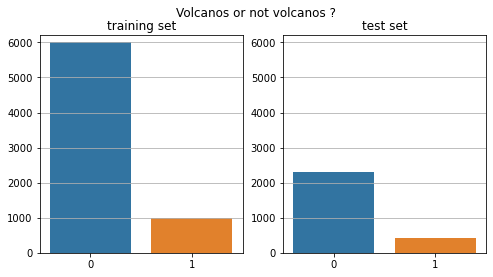

In [5]:
train_counts = y_train['Volcano?'].value_counts()
test_counts = y_test['Volcano?'].value_counts()

# Training set
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.grid(True)
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.title('training set')
plt.ylim([0,6200])
# Test set
plt.subplot(122)
plt.grid(True)
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.title('test set')
plt.ylim([0,6200])
plt.suptitle('Volcanos or not volcanos ?')
plt.show()

### Type of volcanos ?

This time, we will plot the plot to have a quick look on the different probability of having a volcano in the image according to the classification.

Remind from the beginning: 
- Type:
    - 1: definitely a volcano,
    - 2: probably, 
    - 3: possibly, 
    - 4: only a pit is visible.


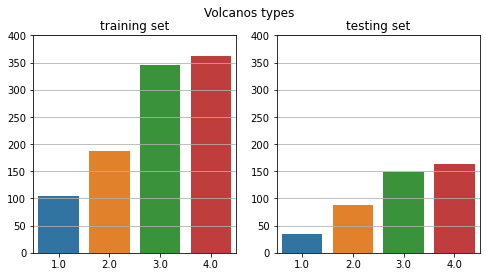

In [6]:
train_type = y_train['Type'].value_counts()
test_type = y_test['Type'].value_counts()

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.grid(True)
sns.barplot(x=train_type.index, y=train_type.values)
plt.title('training set')
plt.ylim([0,400])
plt.subplot(122)
plt.grid(True)
sns.barplot(x=test_type.index, y=test_type.values)
plt.title('testing set')
plt.ylim([0,400])
plt.suptitle('Volcanos types')
plt.show()

### Number of volcanos per images

Another plot to have a look on the number of volcanos labelled per images 

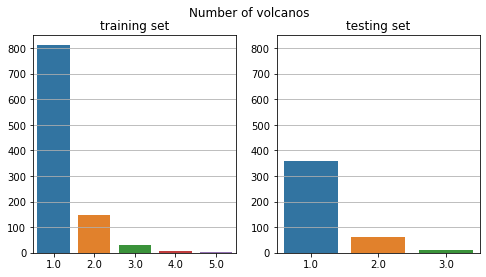

In [7]:
train_nb_volcanos = y_train['Number Volcanoes'].value_counts()
test_nb_volcanos = y_test['Number Volcanoes'].value_counts()

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.grid(True)
sns.barplot(x=train_nb_volcanos.index, y=train_nb_volcanos.values)
plt.title('training set')
plt.ylim([0,850])

plt.subplot(122)
plt.grid(True)
sns.barplot(x=test_nb_volcanos.index, y=test_nb_volcanos.values)
plt.title('testing set')
plt.ylim([0,850])

plt.suptitle('Number of volcanos')
plt.show()

Most of the images just include one volcano.

## Plot randomly some images

Here is a piece of code to plot randomly some images. 
- The line above shows some images with some volcanos.
- The line below shows some images without volcanos.

You can re-run several times the following cells to see different images.

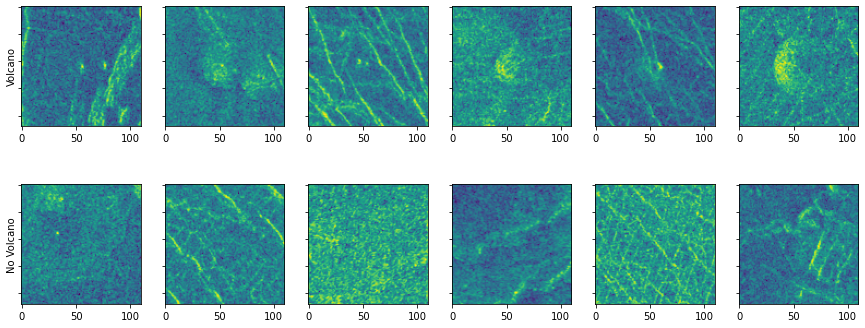

In [8]:
nb_samples = 6 # Number of images selected randomly
pos_samples = X_train[y_train['Volcano?'] == 1].sample(nb_samples)
neg_samples = X_train[y_train['Volcano?'] == 0].sample(nb_samples)

plt.subplots(figsize=(15,6))

for i in range(nb_samples):
    plt.subplot(2, nb_samples, i+1)
    plt.tick_params(labelleft=False)
    plt.imshow(pos_samples.iloc[i,:].values.reshape((110, 110)), cmap='viridis')
    if i == 0: plt.ylabel('Volcano')
    
    
for i in range(nb_samples):
    plt.subplot(2, nb_samples, i+nb_samples+1)
    plt.tick_params(labelleft=False)
    plt.imshow(neg_samples.iloc[i,:].values.reshape((110,110)), cmap='viridis')
    if i == 0: plt.ylabel('No Volcano')
plt.show()

# Preprocessing of the images

The first step is to normalize the images in the range $[0,1]$. Since pixel values are from $0$ to $255$, we just need to devide by $256$.

In [9]:
X_train /= 256.
X_test /=256.

For the moment, images are saved in the files like a vector of data $110x110 = 12100$
In the following, we will reshape those vectors to create some images to feed the CNN.
The shape of each images will be normalised as $(110 x 110 x 1)$. 
The "x $1$" at the end is to take into account possible color images (which is not the case here).

In [10]:
IMAGE_SHAPE = (110, 110, 1) # Image shape that will be used to feed the keras models

## Create a validation set

First, we need to split our test data to test and validation data. 
We will use %50 of test data as validation data. We use the validation data to understand that is there any overfitting problem in our model before testing with test data.

- The **training set** is used to train the model and the **validation set** is used to assess the model performance.

- The **validation set** is used to optimize the model parameters while the **test set** is used to provide an unbiased estimate of the final model.

- Note that adding a random_state is usefull to have always the same split of the data.


In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                test_size=0.5,
                                                random_state=42)

Let's check the shape of the dataset after split:

In [12]:
print("After split train data for valitadion data.")
print(f"X_train -> {X_train.shape} / y_train -> {y_train.shape} (70% of the dataset)") 
print(f"X_test -> {X_test.shape} / y_test -> {y_test.shape} (15% of the dataset)") 
print(f"X_val -> {X_val.shape} / y_val -> {y_val.shape} (15% of the dataset)") 

After split train data for valitadion data.
X_train -> (7000, 12100) / y_train -> (7000, 4) (70% of the dataset)
X_test -> (1367, 12100) / y_test -> (1367, 4) (15% of the dataset)
X_val -> (1367, 12100) / y_val -> (1367, 4) (15% of the dataset)


We need to add one more dimension on each set because Keras wants to know the color channels of the images.

In [13]:
X_test = np.resize(X_test, (1367, 110, 110, 1))
X_train = np.resize(X_train, (7000, 110, 110, 1))
X_val = np.resize(X_val, (1367, 110, 110, 1))

print(f"X_train -> {X_train.shape} / y_train -> {y_train.shape} (70% of the dataset)") 
print(f"X_test -> {X_test.shape} / y_test -> {y_test.shape} (15% of the dataset)") 
print(f"X_val -> {X_val.shape} / y_val -> {y_val.shape} (15% of the dataset)") 

X_train -> (7000, 110, 110, 1) / y_train -> (7000, 4) (70% of the dataset)
X_test -> (1367, 110, 110, 1) / y_test -> (1367, 4) (15% of the dataset)
X_val -> (1367, 110, 110, 1) / y_val -> (1367, 4) (15% of the dataset)


## Drop useless labels
We need to drop the Type, Radius, Number Volcanoes columns from output data. 
Here, we just want to label the images that volcano or not.

Note that you can redo completely the classificatio, not finding if an image has some volcanos or not but to classifify by number of volcanos.


In [14]:
y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]
y_val = y_val["Volcano?"]

### Convert categorical data to matrices

Volcano type are coded in string "0" or "1". To use these labels, we need to convert them to a more expressive way.
Here, we will use the One-Hot-Encoding method which consist in replacing some categorical values into a matrix

| "0" | "1" |
|-----|-----|
|  1  |  0  |
|  0  |  1  |


In [15]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

# Plain CNN model
In the next cell, we are going to create our very first model. 
One layer is made of a `Convolution layer` (which apply some filters on the data) and a `Pooling layer` which takes the maximum.
For more details, we encourage you to come back on the lecture about deep learning.

## Define the model

It's preferable to use a function to define the model. It's easier to create some new models after without rewriting all the line.

In [16]:
def PlainCNN(input_shape, dense_size):
    """
    Very simple model of CNN
    
    1 Convolution layer
    1 Maxpooling layer
    1 Convolution layer
    1 Maxpooling layer
    1 flatten layer
    1 dense layer
    ----
    INPUT:
        @input_shape: (set) shape of the images
        @dense_size: (int) number of output labels
    ----
    OUTPUT:
        @model
    """
    model = Sequential()                            # to stack the layer sequentially
    model.add(Conv2D(filters=8, kernel_size=(5,5),  # 8 filters of size 5x5
                      activation='relu',            # ReLU as activation function
                      input_shape=input_shape))     # initial size of the images
    model.add(MaxPooling2D(pool_size=(2,2)))        # Take the max value per block of 2x2 pixels
    model.add(Conv2D(filters=16, kernel_size=(3,3), 
                      activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())                            # Convert the final image as a vector
    model.add(Dense(dense_size,                     # Apply a sigmoid function (Volcano or not volcano ?)
                    activation="sigmoid"))
    return model


After implementing the your first neural network into a function, on can instantiate it and check on the parameters by calling the .summary() methods.

One can see that in our case, on *only* have about 21000 parameters which is quit few compared to a fully connected network that would have led us to millions of parameters even fo reasonnably small networks.

In [17]:
mymodel1 = PlainCNN(IMAGE_SHAPE, y_train.shape[1])
print(mymodel1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 106, 106, 8)       208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 20002     
Total params: 21,378
Trainable params: 21,378
Non-trainable params: 0
____________________________________________________

2022-01-26 09:32:12.205881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compile and run the model

We are using the training set to train the model and we will test it on the validation set
- In the following cell, we are using the most common optimize which is the `ADAM optimizer` which is a stochastic gradient descent method.
- Since our output are categorical, it's preferable to use the `categorical_crossentropy` loss.


In [18]:
mymodel1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

The last step is to fit the model with the training data
Few parameters to set: 
- `The batch size` is the number of samples that are passed to the network at once.  
- `epoch` is one single pass over the entire training set to the network(feed forward and backpropagation).

Let's say we have 1000 images of volcanos that we want to train our network. Now, let's say we specify our batch size to be 10. This means that 10 images of volcanos will be passed as a group, or as a batch, at one time to the network.

Given that a single epoch is one single pass of all the data through the network, it will take 100 batches to make up full epoch. We have 1000 images divided by a batch size of 10, which equals 100 total batches. 


Mini batches method requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory. Typically networks train faster with mini-batches. That's because we update the weights after each propagation.




In [19]:
model1_trained = mymodel1.fit(X_train, y_train, batch_size=64, epochs=10, 
                             validation_data=(X_val, y_val))

2022-01-26 09:32:12.673076: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
110/110 [==============================] - 32s 286ms/step - loss: 0.4104 - accuracy: 0.8517 - val_loss: 0.4365 - val_accuracy: 0.8427
Epoch 2/10
110/110 [==============================] - 34s 309ms/step - loss: 0.3952 - accuracy: 0.8571 - val_loss: 0.4074 - val_accuracy: 0.8427
Epoch 3/10
110/110 [==============================] - 33s 296ms/step - loss: 0.3531 - accuracy: 0.8601 - val_loss: 0.3504 - val_accuracy: 0.8932
Epoch 4/10
110/110 [==============================] - 32s 289ms/step - loss: 0.2500 - accuracy: 0.9026 - val_loss: 0.2306 - val_accuracy: 0.9283
Epoch 5/10
110/110 [==============================] - 32s 287ms/step - loss: 0.2101 - accuracy: 0.9250 - val_loss: 0.2035 - val_accuracy: 0.9283
Epoch 6/10
110/110 [==============================] - 32s 287ms/step - loss: 0.1628 - accuracy: 0.9416 - val_loss: 0.2063 - val_accuracy: 0.9407
Epoch 7/10
110/110 [==============================] - 31s 285ms/step - loss: 0.1498 - accuracy: 0.9459 - val_loss: 0.2291 - val_ac

<img src="./Images/PlainCNNFit_ScreenShot.png" width="900" align="left" border=1>

#### Let's have a quick look on the results...

- `Epoch 1/10`: since we set "epoch=10", we will have 10 epochs

- `10/110`, `40/110`... `110/110`: we have about 7000 images in the training set and a batch_size=64 -> 7000/64 is about 110. Each batch of images go through the network to train it.
- `loss` and `accuracy` refer to the current loss and accuracy of the training set. 
- At the end of each epoch your trained NN is evaluated against your validation set. This is what `val_loss` and `val_acc` refer to.



## Evaluate the model 

The next cells show how to evaluate the models  

In [20]:
score1 = mymodel1.evaluate(X_test, y_test)
print('Test Loss ->', score1[0])
print('Test Accuracy ->', score1[1])

43/43 [==============================] - 2s 39ms/step - loss: 0.1627 - accuracy: 0.9415
Test Loss -> 0.16270774602890015
Test Accuracy -> 0.9414777159690857


Accuracy is pretty good since 94% of the images with volcanos are pretty well labelled.  

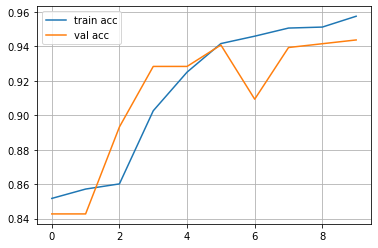

In [21]:
plt.plot(model1_trained.history['accuracy'], label="train acc")
plt.plot(model1_trained.history['val_accuracy'], label="val acc")
plt.grid(True)
plt.legend()
plt.show()

This is one of the most common plot in deep learning : plotting the accuracy of the training. 
For only 5 epochs, we see that it's not suffisant to see if the mode gave it's best.

## ***** TO DO ******

Modify the hyperparameters in the model to see if you can improve the results. 
ie:
- modify the number of neurons in the Conv2D layers (one common rule is to double the number of neurons in each hidden layer. if 8 in the first layer, 16 in the second, 32 in the third...)
- modify the number of epochs (not to much... it could take to much time)
- modify the number of batch_size

In [22]:
# WRITE YOUR CODE HERE

In [23]:
# WRITE YOUR CODE HERE

In [24]:
# WRITE YOUR CODE HERE

In [25]:
# WRITE YOUR CODE HERE

# Another CNN
This time, we will use another CNN with more layer and a new layer called `Dropout` to randomly switch off a fraction of the neurons at each epochs


Remind : 

- Conv layer : Conv2D(filters = 2, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape = (110,110,1))
- Max pooling layer: MaxPool2D(pool_size=(2,2)
- Dropout: Dropout(0.5)
- Flatten layer: Flatten()
- Dense layer: Dense(y_train.shape[1], activation = "sigmoid")


## ********* TODO **********
Implement the following network and train it

- Conv layer with 8 filters of size (3, 3) with the activation function 'relu and the input shape (110,110,1)
- Conv layer with 4 filters of size (3, 3) with the activation function 'relu
- Conv layer with 8 filters of size (5, 5) with the activation function 'relu
- Max Pooling layer with a pool size (2,2)
- Dropout  with a ratio equal to 0.5
- Conv layer with 16 filters of size (5, 5) with the activation function 'relu
- Max Pooling layer with a pool size (2,2)
- Dropout  with a ratio equal to 0.5
- Conv layer with 24 filters of size (7, 7) with the activation function 'relu
- Max Pooling layer with a pool size (2,2)
- Dropout  with a ratio equal to 0.5
- Flatten layer
- Dense layer with a "sigmoid" activation function


In [26]:
def model2(input_shape, dense_size, dp_rate):
    """
    Another model with more layers and dropout
    
    """
    model = Sequential()
    model.add(Conv2D(filters=2, kernel_size=(3,3),
                     padding='same', activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(filters=4, kernel_size=(3,3),
                     padding='same', activation='relu'))
    model.add(Conv2D(filters=8, kernel_size=(5,5),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dp_rate))
    model.add(Conv2D(filters=16, kernel_size=(5,5),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=24, kernel_size=(7,7),
                     padding='same', activation='relu'))
    model.add(Dropout(dp_rate))
    model.add(Flatten())
    model.add(Dense(dense_size, activation="sigmoid"))
    return model
mymodel2 = model2(IMAGE_SHAPE, y_train.shape[1], 0.5)
print(mymodel2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 110, 110, 2)       20        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 4)       76        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 110, 110, 8)       808       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 55, 55, 16)        3216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 16)       

___________________________________________________________
Layer (type)                 Output Shape              Param    
=================================================================
conv2d_5 (Conv2D)            (None, 110, 110, 2)       20        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 110, 110, 4)       76        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 8)       808       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 55, 16)        3216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 24)        18840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 27, 24)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 17496)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34994     
=================================================================
Total params: 57,954
Trainable params: 57,954
Non-trainable params: 0
_________________________________________________________________

Now, `compile`, `fit` and `evaluae` your model.

Did you improve the results ?

In [27]:
# WRITE YOUR CODE HERE

mymodel2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [28]:
# WRITE YOUR CODE HERE
model2_trained = mymodel2.fit(X_train, y_train, batch_size=64, epochs=10, 
                             validation_data=(X_val, y_val))

Epoch 1/10
110/110 [==============================] - 117s 1s/step - loss: 0.4325 - accuracy: 0.8570 - val_loss: 0.4395 - val_accuracy: 0.8427
Epoch 2/10
110/110 [==============================] - 113s 1s/step - loss: 0.4123 - accuracy: 0.8571 - val_loss: 0.4347 - val_accuracy: 0.8427
Epoch 3/10
110/110 [==============================] - 112s 1s/step - loss: 0.4116 - accuracy: 0.8571 - val_loss: 0.4357 - val_accuracy: 0.8427
Epoch 4/10
110/110 [==============================] - 130s 1s/step - loss: 0.3590 - accuracy: 0.8750 - val_loss: 0.3063 - val_accuracy: 0.8976
Epoch 5/10
110/110 [==============================] - 131s 1s/step - loss: 0.2226 - accuracy: 0.9277 - val_loss: 0.2050 - val_accuracy: 0.9320
Epoch 6/10
110/110 [==============================] - 152s 1s/step - loss: 0.1639 - accuracy: 0.9451 - val_loss: 0.1692 - val_accuracy: 0.9451
Epoch 7/10
110/110 [==============================] - 147s 1s/step - loss: 0.1411 - accuracy: 0.9519 - val_loss: 0.1420 - val_accuracy: 0.9546

In [29]:
# WRITE YOUR CODE HERE
score2 = mymodel2.evaluate(X_test, y_test)
print('Test Loss ->', score2[0])
print('Test Accuracy ->', score2[1])

43/43 [==============================] - 6s 148ms/step - loss: 0.1071 - accuracy: 0.9642
Test Loss -> 0.10712727904319763
Test Accuracy -> 0.9641550779342651


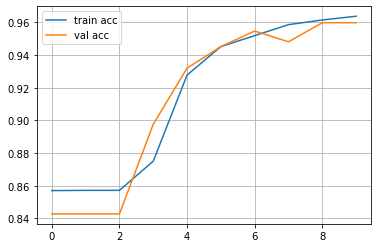

In [30]:
# WRITE YOUR CODE HERE
plt.plot(model2_trained.history['accuracy'], label="train acc")
plt.plot(model2_trained.history['val_accuracy'], label="val acc")
plt.grid(True)
plt.legend()
plt.show()

# Improve the dataset
As we said in introductions, some images are partly blank. Lets try to detect them to improve the model.
This first part is made for you but you will have to train the CNN again with this new dataset.

## Function to detect corrupted images
Just execute it.


In [31]:
# Function from https://www.kaggle.com/behcetsenturk/finding-volcanoes-with-cnn/notebook
def corruptedImages(data):
    corruptedImagesIndex = []
    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0;
        for pixelIndex in range(0,len(image)):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0:
            corruptedImagesIndex.append(index)
        else:
            sum = 0

    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0;
        for pixelIndex in range(0,len(image),110):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0 and index not in corruptedImagesIndex:
            corruptedImagesIndex.append(index)
        else:
            sum = 0
    return corruptedImagesIndex

def deleteCorrupted(X, y, corruptedIndexList):
    for i in corruptedIndexList:
        X.drop(i, inplace=True) # Drop the corrupted
        y.drop(i, inplace=True) 
    
    X.reset_index(inplace=True) # Reconstruct the index
    X.drop(['index'], axis=1, inplace=True) # Delete old index column
    #Because they are pandas.series we don't need to deal with index
    #Because we use inplace=True we don't need to return something

## Have a loo on few corrupted images

In [32]:
subset_Corrupted_train = corruptedImages(X_train)
print(f"There are {len(subset_Corrupted_train)} corrupted images in train set.")

There are 209 corrupted images in train set.


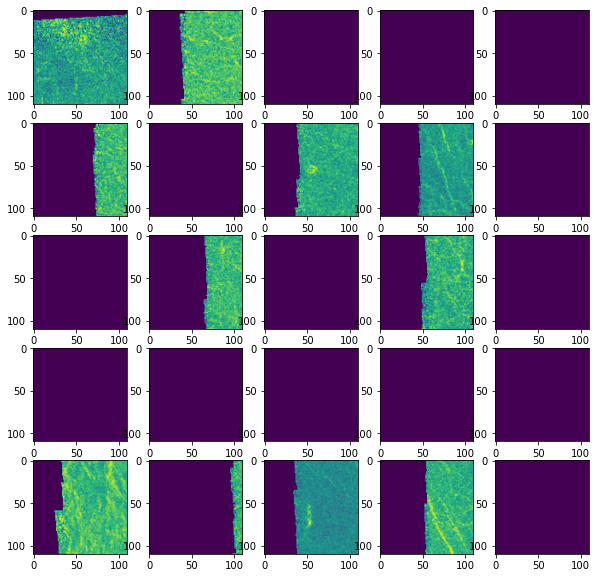

In [33]:
f, axarr = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(X_train[subset_Corrupted_train[i*5+j]])

## Let's delete the corrupted images : 

In [34]:
X_train = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DIR, "train_images.csv"), header=None) # Images / Train
y_train = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DIR, "train_labels.csv")) # Labels / Train
X_test = pd.read_csv(os.path.join(DATA_DIR, TEST_DIR,"test_images.csv"), header=None) # Images / Test
y_test = pd.read_csv(os.path.join(DATA_DIR, TEST_DIR,"test_labels.csv")) # Labels / Test

print(f"- X_train shape: {X_train.shape}")
print(f"- y_train shape: {y_train.shape}")
print(f"- X_test shape : {X_test.shape}")
print(f"- y_test shape : {y_test.shape}")
trainCorruptedList = corruptedImages(X_train)
testCorruptedList = corruptedImages(X_test)

deleteCorrupted(X_train, y_train, trainCorruptedList)
deleteCorrupted(X_test, y_test, testCorruptedList)

- X_train shape: (7000, 12100)
- y_train shape: (7000, 4)
- X_test shape : (2734, 12100)
- y_test shape : (2734, 4)


## Prepare your new dataset for training

In [35]:
# Get our label
y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]

# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# One Hot Label encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

# Spliting
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Lastly resizing
X_test = np.resize(X_test, (X_test.shape[0], 110, 110, 1))
X_train = np.resize(X_train, (X_train.shape[0], 110, 110, 1))
X_val = np.resize(X_val, (X_val.shape[0], 110, 110, 1))

## ********* TODO **********
Train the models again with the new data set to see if we improved the results.

In [36]:
# WRITE YOUR CODE HERE
# WRITE YOUR CODE HERE
model3_trained = mymodel1.fit(X_train, y_train, batch_size=64, epochs=10, 
                             validation_data=(X_val, y_val))

Epoch 1/10
107/107 [==============================] - 36s 339ms/step - loss: 0.1205 - accuracy: 0.9569 - val_loss: 0.1696 - val_accuracy: 0.9450
Epoch 2/10
107/107 [==============================] - 39s 361ms/step - loss: 0.1107 - accuracy: 0.9601 - val_loss: 0.2503 - val_accuracy: 0.9270
Epoch 3/10
107/107 [==============================] - 41s 382ms/step - loss: 0.1087 - accuracy: 0.9617 - val_loss: 0.2035 - val_accuracy: 0.9330
Epoch 4/10
107/107 [==============================] - 37s 346ms/step - loss: 0.1040 - accuracy: 0.9645 - val_loss: 0.1700 - val_accuracy: 0.9465
Epoch 5/10
107/107 [==============================] - 39s 362ms/step - loss: 0.1001 - accuracy: 0.9651 - val_loss: 0.1984 - val_accuracy: 0.9435
Epoch 6/10
107/107 [==============================] - 37s 349ms/step - loss: 0.0983 - accuracy: 0.9663 - val_loss: 0.1838 - val_accuracy: 0.9473
Epoch 7/10
107/107 [==============================] - 39s 369ms/step - loss: 0.0874 - accuracy: 0.9694 - val_loss: 0.1750 - val_ac

In [37]:
# WRITE YOUR CODE HERE
score3 = mymodel1.evaluate(X_test, y_test)
print('Test Loss ->', score3[0])
print('Test Accuracy ->', score3[1])

42/42 [==============================] - 2s 47ms/step - loss: 0.1520 - accuracy: 0.9495
Test Loss -> 0.15203940868377686
Test Accuracy -> 0.9495101571083069


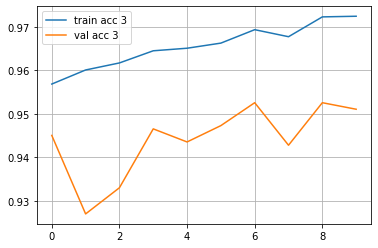

In [38]:
# WRITE YOUR CODE HERE
plt.plot(model3_trained.history['accuracy'], label="train acc 3")
plt.plot(model3_trained.history['val_accuracy'], label="val acc 3")
plt.grid(True)
plt.legend()
plt.show()

Notebook inspired by https://www.kaggle.com/behcetsenturk/finding-volcanoes-with-cnn/notebook

---
<img src="./Images/IPGP_UP_couleur2.png" width="150" align="left" style="vertical-align:middle"> <h4>Earth Data Science Team - January 2022</h4>